# Example: Grid Analysis Results

Last Verified to Run: 2022-02-11<br>
Verified Stack Release: v23.0.0

## Introduction

The purpose of this notebook is to demonstrate the methodology behind the sensor distortion analysis using an dataset of projected spot grid images, as well as to serve as a tutorial for exploring these results by interacting with a Gen 3 Repository. The data products shown here were generated by running the `mixcoatl.characterizeSpots.CharacterizeSpotsTask`, `mixcoatl.gridFitTask.GridFitTask`, and `mixcotal.gridCalibrationTask.GridCalibrationTask`, using the pipetask YAML file `gridAnalysis.yaml` found in `mixcoatl/pipelines`.

In [1]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   g7ae64ea4b3+cca76d10ca 	w_latest w_2021_52 current setup


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np

## DM Stack imports
from lsst.daf.butler import Butler

## MixCOATL imports
from mixcoatl.sourcegrid import DistortedGrid

## Gen 3 repo (spot grid image data only)
repo = '/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft'

## Exploring a Gen 3 Repository

A Butler object can be initialized using the filepath to the repository YAML file. The LSSTCam BOT Gen 3 repository is located on the SLAC SDF, and is split between a number of smaller repositories.  The repository containing the datasets corresponding to the spot grid data acquisition runs during the nine-raft testing period is located at `/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/`. While the Butler itself is used for retrieving a dataset from the repository, the registry is useful for performing queries on datasets, exploring "collections" of datasets, and determining dataset types.

In [3]:
butler = Butler(repo)
registry = butler.registry

Here the registry is used to query all the "collections" within the repository and print a sub-set of relevant collections.

In [4]:
## Display collections in the repository
for collection in registry.queryCollections('u/asnyder/spot*'):
    print(collection)

u/asnyder/spot/gridcalibration
u/asnyder/spot/gridcalibration/20210621T230400Z
u/asnyder/spot/e2v_analysis
u/asnyder/spot/e2v_analysis/20210623T223607Z
u/asnyder/spot/e2v_calibration
u/asnyder/spot/e2v_calibration/20210624T202522Z
u/asnyder/spot/e2v_analysis_rerun
u/asnyder/spot/e2v_analysis_rerun/20210625T023014Z
u/asnyder/spots/e2v_calibration_rerun
u/asnyder/spots/e2v_calibration_rerun/20210625T185250Z
u/asnyder/spot/itl_analysis
u/asnyder/spot/itl_analysis/20210707T222218Z
u/asnyder/spot/itl_calibration
u/asnyder/spot/itl_calibration/20210708T035702Z


Consider the following collections associated with analysis of an ITL CCD:

1. The collection `u/asnyder/spot/itl_analysis` is a CHAINED collection that links a number of children collections, including `LSST-UCDCam/raw/all`, that are associated with a crosstalk analysis.In this case it links to a specific RUN collection `u/asnyder/spot/itl_analysis/20210707T222218Z` that holds the data products for this run.
2. The collection `u/asnyder/spot/itl_calibration` is a CALIBRATION collection that contains data products registered as being used in image calibration. In this instance it contains the resulting superbias image that has been certified in the butler using `butler certify-calibrations`

When querying the repository for dataset references it is important to know the fields available for query. This can be determined using the `registry`.

In [5]:
## Display list of dataset fields
print(registry.dimensions["exposure"].RecordClass.fields)

exposure: 
  instrument: str
  id: int
  physical_filter: str
  obs_id: str
  exposure_time: float
  dark_time: float
  observation_type: str
  observation_reason: str
  day_obs: int
  seq_num: int
  group_name: str
  group_id: int
  target_name: str
  science_program: str
  tracking_ra: float
  tracking_dec: float
  sky_angle: float
  zenith_angle: float
  timespan: lsst.daf.butler.Timespan


# Grid Analysis Results

To obtain the results corresponding to the analysis of the BOT Run 2 data, first the dataset references for the calibrated images within the corresponding collection are obtained using the `registry`, by specifying the dataset type and the collection.

For the spot grid analysis, the relevant dataset types are:

* `raw`: The raw CCD image.
* `postISRCCD`: The post-ISR CCD image used for the spot grid analysis.
* `bias`: The calibration superbias CCD image used during ISR.
* `spotSrc`: The catalog of sources and their measured properties detected in each post-ISR CCD image.
* `gridSpotSrc`: The catalog of sources after being fit to a grid model, calculated for each original source catalog.
* `gridCalibration`: The calibration Astropy Table containing the mean properties and optical distortions of the grid model.

## Spot Grid Image Example

As an example we will start with the collection `u/asnyder/spot/itl_analysis`, which is data run 6865D consisting of spot grid images for random projector dithers across the a single ITL CCD. To get the `postISRCCD` datasets we start by constructing an SQL-like query and select the RUN collection corresponding to the analysis of this data run.  The `registry.queryDatasets()` method is used to get a generator of the dataset references corresponding to our query that can be converted into a list and sorted by exposure ID.

In [6]:
## Construct dataset query
run_num = '6865D'
#detector = 58

collections = 'u/asnyder/spot/itl_analysis'
where = "instrument='LSSTCam'" + \
    " and exposure.observation_type='spot'" + \
    " and exposure.science_program='{0}'".format(run_num)

dataset_refs = list(registry.queryDatasets('postISRCCD', collections=collections,
                                           where=where))
dataset_refs.sort(key=lambda x: x.dataId['exposure'])
print('Number of calibrated images: {0}'.format(len(dataset_refs)))

Number of calibrated images: 1600


An example `postISRCCD` dataset is obtained by selecting a dataset reference from the list of dataset references and using the `butler.get()` method. Each spot grid image consists of a 49 by 49 grid of small spots, slightly larger than the expected size of PSF stars. Because of the nature of the projector optics, the outer regions of the spot grid suffer from vignetting and other optical distortions. In order to make the full grid visible, a logarithmically scaled color scale is used with linear scaling between +/- 10.

Text(0.5, 1.0, 'R02/S02 postISRCCD: 3019103100915')

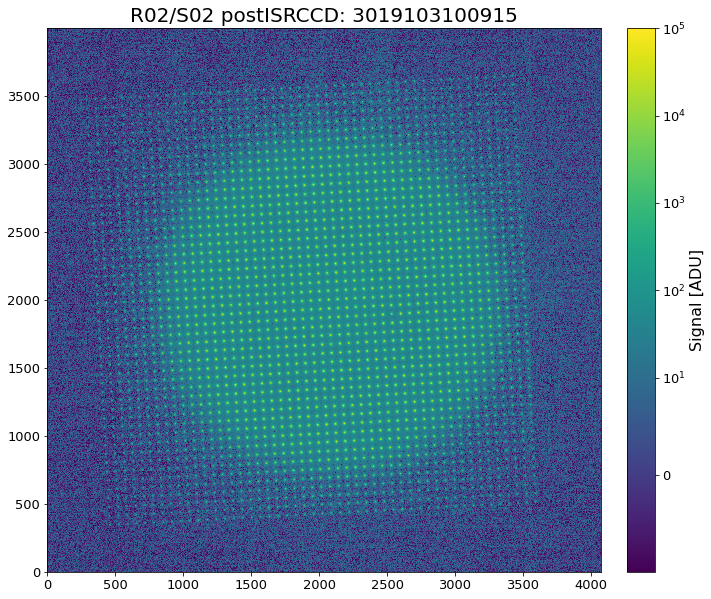

In [7]:
ref = dataset_refs[1000]
data_id = ref.dataId['exposure']
calexp = butler.get(ref, collections='u/asnyder/spot/itl_analysis')
raft_name, sensor_name = calexp.getDetector().getName().split('_')

## Display calibrated image
fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')
im = ax.imshow(calexp.getImage().getArray(), interpolation='none', origin='lower',
               norm=SymLogNorm(10, vmin=-10, vmax=100000, base=10))
    
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Signal [ADU]', fontsize=16)
cbar.ax.tick_params(labelsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_title('{0}/{1} postISRCCD: {2}'.format(raft_name, sensor_name, data_id), fontsize=20)

## Source Catalog Examples

It is easy to obtain datasets associated with a specific dataset reference using the `butler.get()` method, although the syntax is modified slightly.  If we wish to obtain the `spotSrc` dataset, which is the catalog of sources detected in the `postISRCCD` dataset image, we must specify our desired dataset type and the data ID of the dataset reference.

The `spotSrc` dataset is a `SourceCatalog` object, consisting of table of detected sources and a large number of calculated properties such as centroid, shapes, fluxes, etc. This can be viewed easily by converting to an `astropy.table.Table`.

In [8]:
source_catalog = butler.get('spotSrc', dataId=ref.dataId, collections=collections)

source_catalog.asAstropy()

id,coord_ra,coord_dec,parent,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeBj_flag_badCentroid,ext_shapeHSM_HsmShapeKsb_flag_badCentroid,ext_shapeHSM_HsmShapeLinear_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeBj_flag_badCentroid_edge,ext_shapeHSM_HsmShapeKsb_flag_badCentroid_edge,ext_shapeHSM_HsmShapeLinear_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeBj_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeKsb_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeLinear_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeBj_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeKsb_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeLinear_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmShapeBj_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmShapeKsb_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmShapeLinear_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmShapeBj_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmShapeKsb_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmShapeLinear_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,ext_shapeHSM_HsmPsfMoments_flag_badCe

Column data can be obtained from the source catalog by using the table column name. Below, the source centroids determined using the SDSS centroid measurement algorithm (`base_SdssCentroid_x` and `base_SdssCentroid_y`) are used to make a scatter plot of the detected sources from the calibrated image. The corresponding footprint flux measurement from the SDSS shape measurement algorithm (`base_SdssShape_instFlux`) is used as the color scale of each plotted point.

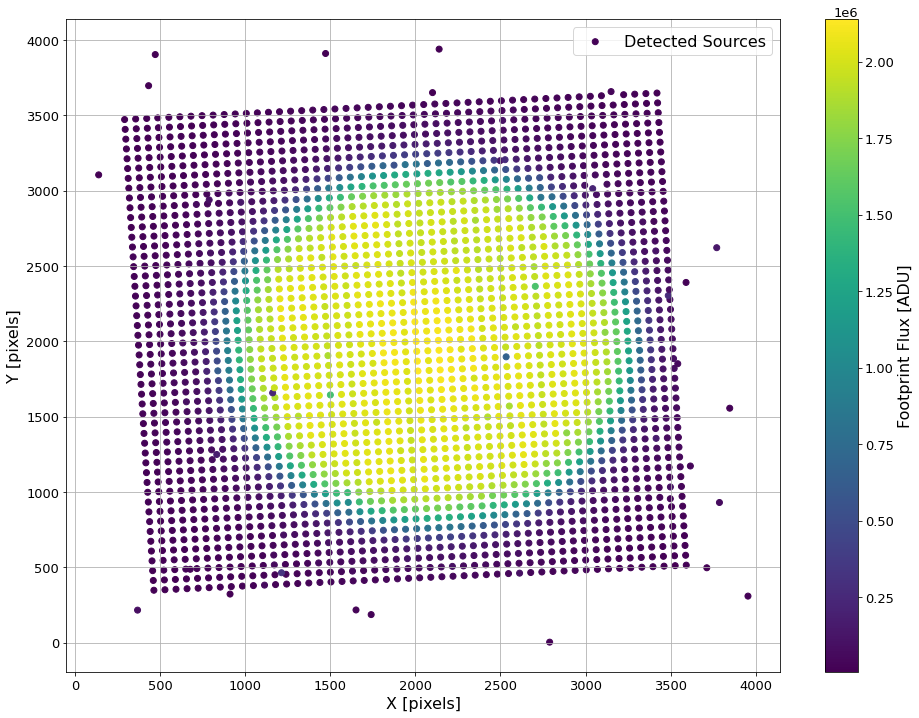

In [9]:
src_y = source_catalog['base_SdssCentroid_y']
src_x = source_catalog['base_SdssCentroid_x']
src_flux = source_catalog['base_SdssShape_instFlux']

fig, ax = plt.subplots(1, 1, figsize=(16, 12), facecolor='white')
im = ax.scatter(src_x, src_y, c=src_flux, label='Detected Sources')
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=13)
ax.set_ylabel('Y [pixels]', fontsize=16)
ax.set_xlabel('X [pixels]', fontsize=16)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Footprint Flux [ADU]', fontsize=16)
cbar.ax.tick_params(labelsize=13)
cbar.ax.yaxis.offsetText.set_fontsize(13)

Following the grid fit analysis performed by `mixcoatl.gridFitTask.GridFitTask`, new catalogs of dataset type `gridSpotSrc` are produced that contain all the catalog information from the original `spotSrc`, but append a set of new columns containing new derived quantities following the determination of the best fit model of an ideal grid to the detected sources.  

The new column `spotgrid_index` is useful to determine which detected sources have been properly matched to a correspond source in the 49 by 49 projected grid; a matched source will have an index between 0 and 2400.

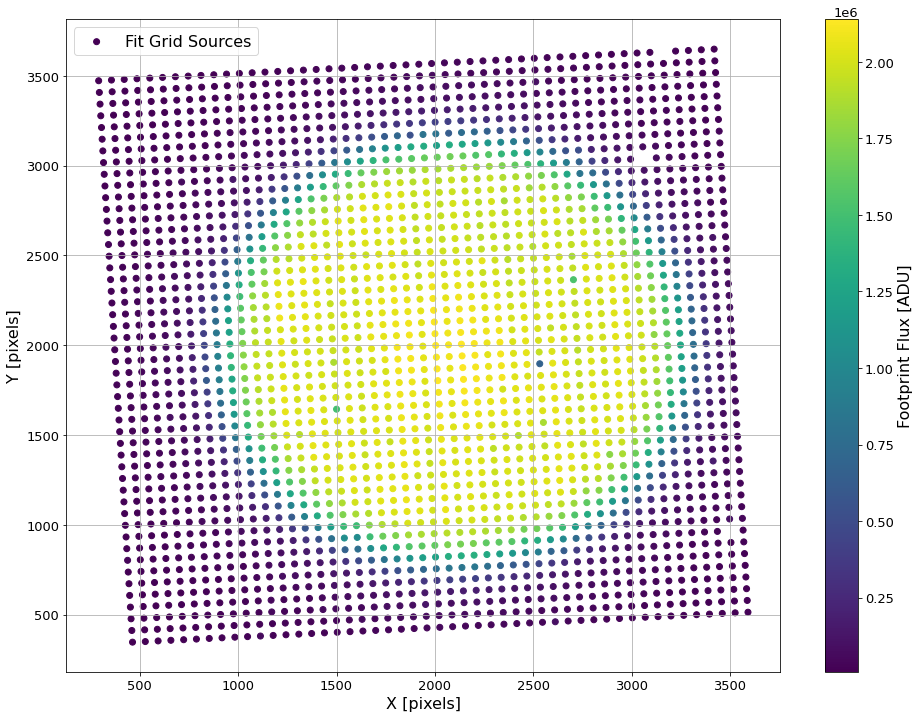

In [10]:
fit_catalog = butler.get('gridSpotSrc', dataId=ref.dataId, collections=collections)

select = fit_catalog['spotgrid_index'] >= 0.

fit_src_y = fit_catalog['base_SdssCentroid_y'][select]
fit_src_x = fit_catalog['base_SdssCentroid_x'][select]
fit_src_flux = source_catalog['base_SdssShape_instFlux'][select]

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
im = ax.scatter(fit_src_x, fit_src_y, c=fit_src_flux, label='Fit Grid Sources')
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=13)
ax.set_ylabel('Y [pixels]', fontsize=16)
ax.set_xlabel('X [pixels]', fontsize=16)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Footprint Flux [ADU]', fontsize=16)
cbar.ax.tick_params(labelsize=13)
cbar.ax.yaxis.offsetText.set_fontsize(13)

Additionally, the processed `gridSpotSrc` catalogs will contain information regarding the parameters (grid center x/y, grid rotation, column/row spacing) of the best fit ideal grid model.  This information is stored in the catalog metadata, and can be obtained as follows:

In [11]:
metadata = fit_catalog.getMetadata()
print(metadata)

BASE_CIRCULARAPERTUREFLUX_RADII = [ 3.0000000000000, 4.5000000000000, 6.0000000000000, 9.0000000000000, 12.000000000000, 17.000000000000, 25.000000000000, 35.000000000000, 50.000000000000, 70.000000000000 ]
NOISE_SEED_MULTIPLIER = 1
NOISE_SOURCE = "measure"
NOISE_OFFSET = 0.0000000000000
NOISE_EXPOSURE_ID = 0
BOTXCAM = -295.80688287354
BOTYCAM = 40.399949655914
GRID_X0 = 1939.9479546245
GRID_Y0 = 1995.5197602507
GRID_THETA = 0.054835099880263
GRID_XSTEP = 65.311040199639
GRID_YSTEP = 65.323578190914
GRID_NCOLS = 49
GRID_NROWS = 49



## Grid Calibration Results

Determination of the component of the flux, position, or shape distortions to the projected grid sources caused by optics or mask imperfections is performed by taking the per-spot average of each property over a large number of images where the grid is dithered across the CCD. This averaging process is done using `mixcoatl.gridCalibrationTask.GridCalibrationTask` and produces an `astropy.table.Table` that acts as a calibration table for the projected grid.

In [12]:
collections = 'u/asnyder/spot/itl_calibration'
ref = list(registry.queryDatasets('gridCalibration', collections=collections))[0]

calib_table = butler.get(ref, collections=collections)

calib_table

spotgrid_index,spotgrid_normalized_dy,spotgrid_normalized_dx,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxErr,base_SdssShape_yyErr,base_SdssShape_xyErr,base_SdssShape_x,base_SdssShape_y,base_SdssShape_instFlux,base_SdssShape_instFluxErr,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,ext_shapeHSM_HsmPsfMoments_x,ext_shapeHSM_HsmPsfMoments_y,ext_shapeHSM_HsmPsfMoments_xx,ext_shapeHSM_HsmPsfMoments_yy,ext_shapeHSM_HsmPsfMoments_xy,ext_shapeHSM_HsmShapeBj_e1,ext_shapeHSM_HsmShapeBj_e2,ext_shapeHSM_HsmShapeBj_sigma,ext_shapeHSM_HsmShapeBj_resolution,ext_shapeHSM_HsmShapeKsb_g1,ext_shapeHSM_HsmShapeKsb_g2,ext_shapeHSM_HsmShapeKsb_sigma,ext_shapeHSM_HsmShapeKsb_resolution,ext_shapeHSM_HsmShapeLinear_e1,ext_shapeHSM_HsmShapeLinear_e2,ext_shapeHSM_HsmShapeLinear_sigma,ext_shapeHSM_HsmShapeLinear_resolution,ext_shapeHSM_HsmShapeRegauss_e1,ext_shapeHSM_HsmShapeRegauss_e2,ext_shapeHSM_HsmShapeRegauss_sigma,ext_shapeHSM_HsmShapeRegauss_resolution,ext_shapeHSM_HsmSourceMoments_x,ext_shapeHSM_HsmSourceMoments_y,ext_shapeHSM_HsmSourceMoments_xx,ext_shapeHSM_HsmSourceMoments_yy,ext_shapeHSM_HsmSourceMoments_xy,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_instFluxErr,base_CircularApertureFlux_12_0_instFlux,base_CircularApertureFlux_12_0_instFluxErr,base_CircularApertureFlux_17_0_instFlux,base_CircularApertureFlux_17_0_instFluxErr,base_CircularApertureFlux_25_0_instFlux,base_CircularApertureFlux_25_0_instFluxErr,base_CircularApertureFlux_35_0_instFlux,base_CircularApertureFlux_35_0_instFluxErr,base_CircularApertureFlux_50_0_instFlux,base_CircularApertureFlux_50_0_instFluxErr,base_CircularApertureFlux_70_0_instFlux,base_CircularApertureFlux_70_0_instFluxErr,base_GaussianFlux_instFlux,base_GaussianFlux_instFluxErr,base_PsfFlux_instFlux,base_PsfFlux_instFluxErr,base_PsfFlux_area,base_ClassificationExtendedness_value,base_FootprintArea_value
,,,pix,pix,pix2,pix2,pix2,pix2,pix2,pix2,pix,pix,ct,ct,pix2,pix2,pix2,ct pix2,ct pix2,ct pix2,pix,pix,pix2,pix2,pix2,,,,,,,,,,,,,,,,,pix,pix,pix2,pix2,pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,pix,,pix
int32,float64,float64,float32,float32,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64
0,0.04897568506698473,0.03665226936656039,0.12827264,0.1291484,5.74404913857055,5.8460245892371745,0.3900160784014212,0.28971946,0.20714606,0.29487416,586.8760928382427,344.2850270392508,8343.514741257546,210.31335103397328,2.2499447646141095,2.2499447646141095,0.0,-30.485891,-2.0672245,-31.031193,-5.614106030549762e-05,-5.614106029566276e-05,2.2494517898741293,2.2494517898741293,-4.3345583313119626e-18,-0.014673967880825353,0.11755802992934587,0.03067244462355245,0.6121131612684033,-0.007517996830070828,0.05897784951452614,0.01538770917137229,0.6104834364999521,-0.014729506528806906,0.1179928967176453,0.03067244462355245,0.6121131612684033,-0.014686701619675297,0.11731163362501361,0.029304662213125644,0.6122821999969651,586.9366374272686,344.3159167558763,5.747361144703288,5.845948637857013,0.39100232915090066,4623.853344095941,80.32258657758086,6841.1824654

A `mixcoatl.sourcegrid.DistortedGrid` objects gives an useful interface for extracting information about the calibrated centroid shifts of each spot from the ideal grid model position. This is useful because the centroid shifts stored in the original calibration table are normalized in such a way to preserve their value under magnification or rotation of the source grid.

The calibrated centroid shifts of the projected grid of spots is plotted below using a quiver plot.

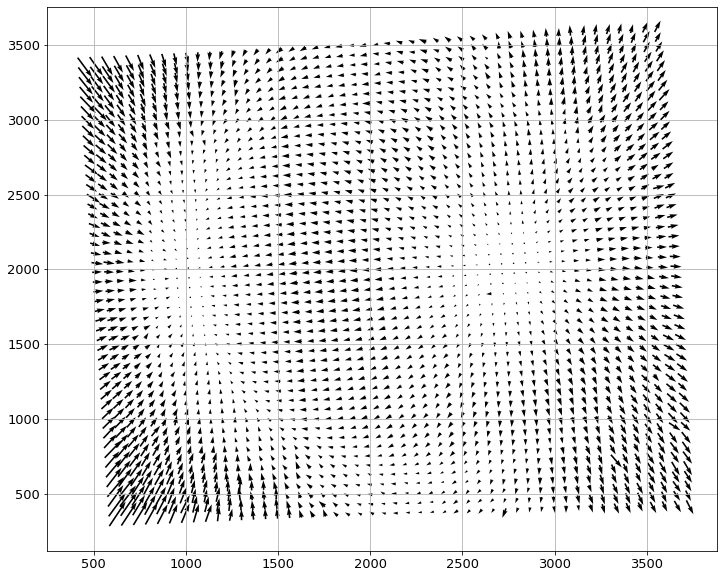

In [13]:
grid = DistortedGrid.from_astropy(calib_table)
y, x = grid.get_centroids()
dy, dx = grid.get_centroid_shifts()

fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')
ax.quiver(x, y, dx, dy)
ax.grid()
ax.tick_params(axis='both', labelsize=13)

This can be combined with the calibrated second moment measurements of each spot.

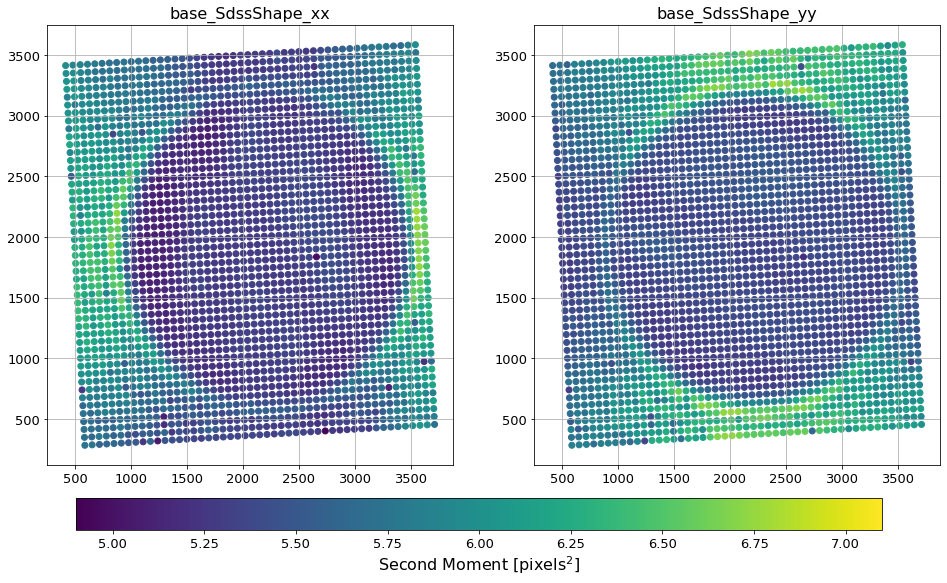

In [14]:
xx = calib_table['base_SdssShape_xx']
yy = calib_table['base_SdssShape_yy']

fig, ax = plt.subplots(1, 2, figsize=(16, 9), facecolor='white')
im0 = ax[0].scatter(x, y, c=xx, vmin=4.9, vmax=7.1)
im1 = ax[1].scatter(x, y, c=yy, vmin=4.9, vmax=7.1)
ax[0].set_title('base_SdssShape_xx', fontsize=16)
ax[0].grid()
ax[0].tick_params(axis='both', labelsize=13)
ax[1].set_title('base_SdssShape_yy', fontsize=16)
ax[1].grid()
ax[1].tick_params(axis='both', labelsize=13)
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.05])
cbar = fig.colorbar(im0, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=13)
cbar.set_label(r'Second Moment [$\mathrm{pixels}^2$]', fontsize=16)